In [2]:
import re
import pandas as pd
from collections import defaultdict
import operator
from pprint import pprint

# Set Pandas to display all rows of dataframes
pd.set_option('display.max_rows', 500)

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
books = ["data/Wilde, Oscar - The Picture of Dorian Gray.txt"]

In [4]:
bookDict = defaultdict(dict)
for book in books:
    title = book.split('-')[1].strip().split('.')[0]
    with open(book, 'r') as f:
        text = (f.read())
    print(title)
    splitTxt = text.splitlines()
    chapterName = ''
    startReading = False
    for line in splitTxt:
        if line == 'THE PREFACE':
            bookDict[title][line] = []
            chapterName = line
            startReading = True
        elif line[:7] == 'CHAPTER':
            bookDict[title][line] = []
            chapterName = line
        elif startReading == True:
            bookDict[title][chapterName].append(line)
    for chapter in bookDict[title]:
        bookDict[title][chapter] = ' '.join(bookDict[title][chapter]).strip()

The Picture of Dorian Gray


In [5]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [6]:
# Convert to list
data = [bookDict[book][chapter] for book in bookDict for chapter in bookDict[book]]
print(data[0])

The artist is the creator of beautiful things.  To reveal art and conceal the artist is art's aim.  The critic is he who can translate into another manner or a new material his impression of beautiful things.  The highest as the lowest form of criticism is a mode of autobiography. Those who find ugly meanings in beautiful things are corrupt without being charming.  This is a fault.  Those who find beautiful meanings in beautiful things are the cultivated.  For these there is hope.  They are the elect to whom beautiful things mean only beauty.  There is no such thing as a moral or an immoral book.  Books are well written, or badly written.  That is all.  The nineteenth century dislike of realism is the rage of Caliban seeing his own face in a glass.  The nineteenth century dislike of romanticism is the rage of Caliban not seeing his own face in a glass.  The moral life of man forms part of the subject-matter of the artist, but the morality of art consists in the perfect use of an imperf

In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['the', 'artist', 'is', 'the', 'creator', 'of', 'beautiful', 'things', 'to', 'reveal', 'art', 'and', 'conceal', 'the', 'artist', 'is', 'art', 'aim', 'the', 'critic', 'is', 'he', 'who', 'can', 'translate', 'into', 'another', 'manner', 'or', 'new', 'material', 'his', 'impression', 'of', 'beautiful', 'things', 'the', 'highest', 'as', 'the', 'lowest', 'form', 'of', 'criticism', 'is', 'mode', 'of', 'autobiography', 'those', 'who', 'find', 'ugly', 'meanings', 'in', 'beautiful', 'things', 'are', 'corrupt', 'without', 'being', 'charming', 'this', 'is', 'fault', 'those', 'who', 'find', 'beautiful', 'meanings', 'in', 'beautiful', 'things', 'are', 'the', 'cultivated', 'for', 'these', 'there', 'is', 'hope', 'they', 'are', 'the', 'elect', 'to', 'whom', 'beautiful', 'things', 'mean', 'only', 'beauty', 'there', 'is', 'no', 'such', 'thing', 'as', 'moral', 'or', 'an', 'immoral', 'book', 'books', 'are', 'well', 'written', 'or', 'badly', 'written', 'that', 'is', 'all', 'the', 'nineteenth', 'century', 'd

In [8]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['the', 'artist', 'is', 'the', 'creator', 'of', 'beautiful', 'things', 'to', 'reveal', 'art', 'and', 'conceal', 'the', 'artist', 'is', 'art', 'aim', 'the', 'critic', 'is', 'he', 'who', 'can', 'translate', 'into', 'another', 'manner', 'or', 'new', 'material', 'his', 'impression', 'of', 'beautiful', 'things', 'the', 'highest', 'as', 'the', 'lowest', 'form', 'of', 'criticism', 'is', 'mode', 'of', 'autobiography', 'those', 'who', 'find', 'ugly', 'meanings', 'in', 'beautiful', 'things', 'are', 'corrupt', 'without', 'being', 'charming', 'this', 'is', 'fault', 'those', 'who', 'find', 'beautiful', 'meanings', 'in', 'beautiful', 'things', 'are', 'the', 'cultivated', 'for', 'these', 'there', 'is', 'hope', 'they', 'are', 'the', 'elect', 'to', 'whom', 'beautiful', 'things', 'mean', 'only', 'beauty', 'there', 'is', 'no', 'such', 'thing', 'as', 'moral', 'or', 'an', 'immoral', 'book', 'books', 'are', 'well', 'written', 'or', 'badly', 'written', 'that', 'is', 'all', 'the', 'nineteenth_century', 'disli

In [9]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc])# if token.pos_ in allowed_postags])
    return texts_out

In [10]:
 # Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['artist', 'creator', 'beautiful', 'thing', 'reveal', 'art', 'conceal', 'artist', 'art', 'aim', 'critic', 'translate', 'another', 'manner', 'new', 'material', 'impression', 'beautiful', 'thing', 'highest', 'low', 'form', 'criticism', 'mode', 'autobiography', 'find', 'ugly', 'meaning', 'beautiful', 'thing', 'corrupt', 'without', 'charm', 'fault', 'find', 'beautiful', 'meaning', 'beautiful', 'thing', 'cultivate', 'hope', 'elect', 'beautiful', 'thing', 'mean', 'beauty', 'thing', 'moral', 'immoral', 'book', 'book', 'well', 'write', 'badly', 'write', 'nineteenth_century', 'dislike', 'realism', 'rage', 'caliban', 'see', 'face', 'glass', 'nineteenth_century', 'dislike', 'romanticism', 'rage', 'caliban', 'see', 'face', 'glass', 'moral', 'life', 'man', 'form', 'part', 'subject', 'matter', 'artist', 'morality', 'art', 'consist', 'perfect', 'use', 'imperfect', 'medium', 'artist', 'desire', 'prove', 'anything', 'even', 'thing', 'true', 'proved', 'artist', 'ethical', 'sympathy', 'ethical', 'sympat

In [11]:
print(data_lemmatized[5])

['mother', 'mother', 'happy', 'whisper', 'girl', 'bury', 'face', 'lap', 'fade', 'tired', 'look', 'woman', 'back', 'turn', 'shrill', 'intrusive', 'light', 'sit', 'one', 'arm', 'chair', 'dingy', 'sitting', 'room', 'contain', 'happy', 'repeat', 'must', 'happy', 'mrs', 'vane', 'wince', 'put', 'thin', 'bismuth', 'whiten', 'hand', 'daughter', 'head', 'happy', 'echo', 'happy', 'sibyl', 'see', 'act', 'must', 'think', 'anything', 'act', 'mr', 'isaac', 'good', '-PRON-', 'owe', 'money', 'girl', 'look', 'pout', 'money', 'mother', 'cry', 'money', 'matter', 'love', 'money', 'mr', 'isaac', 'advance', '-PRON-', 'fifty', 'pound', 'pay', 'debt', 'get', 'proper', 'outfit', 'jame', 'must', 'forget', 'sibyl', 'fifty', 'pound', 'large', 'sum', 'mr', 'isaacs', 'considerate', 'gentleman', 'mother', 'hate', 'way', 'talk', 'say', 'girl', 'rise', 'foot', 'go', 'window', 'know', 'could', 'manage', 'without', 'answer', 'eld', 'woman', 'querulously', 'sibyl_vane', 'toss', 'head', 'laugh', 'want', 'mother', 'prince_

In [12]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 11), (7, 11), (8, 1), (9, 1), (10, 6), (11, 1), (12, 1), (13, 2), (14, 2), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 2), (23, 1), (24, 1), (25, 1), (26, 1), (27, 2), (28, 1), (29, 1), (30, 2), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 2), (37, 1), (38, 1), (39, 2), (40, 1), (41, 3), (42, 2), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 2), (53, 1), (54, 1), (55, 2), (56, 2), (57, 1), (58, 1), (59, 2), (60, 1), (61, 1), (62, 2), (63, 1), (64, 1), (65, 1), (66, 2), (67, 1), (68, 1), (69, 1), (70, 2), (71, 2), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 2), (78, 2), (79, 1), (80, 1), (81, 1), (82, 2), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 2), (89, 1), (90, 1), (91, 1), (92, 1), (93, 2), (94, 2), (95, 2), (96, 9), (97, 1), (98, 1), (99, 1), (100, 2), (101, 1), (102, 1), (103, 1), (104, 1), (105, 2), (106, 1), (107, 2), (108, 1), (109, 1), (110, 

In [13]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('accord', 1),
  ('actor', 1),
  ('admire', 2),
  ('aim', 1),
  ('another', 1),
  ('anything', 1),
  ('art', 11),
  ('artist', 11),
  ('autobiography', 1),
  ('badly', 1),
  ('beautiful', 6),
  ('beauty', 1),
  ('beneath', 1),
  ('book', 2),
  ('caliban', 2),
  ('charm', 1),
  ('complex', 1),
  ('conceal', 1),
  ('consist', 1),
  ('corrupt', 1),
  ('craft', 1),
  ('creator', 1),
  ('critic', 2),
  ('criticism', 1),
  ('cultivate', 1),
  ('desire', 1),
  ('disagree', 1),
  ('dislike', 2),
  ('diversity', 1),
  ('elect', 1),
  ('ethical', 2),
  ('even', 1),
  ('ever', 1),
  ('everything', 1),
  ('excuse', 1),
  ('express', 1),
  ('face', 2),
  ('fault', 1),
  ('feeling', 1),
  ('find', 2),
  ('forgive', 1),
  ('form', 3),
  ('glass', 2),
  ('go', 1),
  ('highest', 1),
  ('hope', 1),
  ('immoral', 1),
  ('imperfect', 1),
  ('impression', 1),
  ('instrument', 1),
  ('intensely', 1),
  ('language', 1),
  ('life', 2),
  ('long', 1),
  ('low', 1),
  ('make', 2),
  ('man', 2),
  ('manner', 1

In [14]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [15]:
# Print the Keyword in the 20 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.019*"one" + 0.017*"dorian" + 0.012*"say" + 0.011*"harry" + '
  '0.010*"lord_henry" + 0.009*"thing" + 0.009*"life" + 0.008*"never" + '
  '0.007*"know" + 0.007*"always"'),
 (1,
  '0.011*"lord_henry" + 0.011*"one" + 0.011*"say" + 0.009*"thing" + '
  '0.007*"tell" + 0.007*"duchess" + 0.007*"art" + 0.006*"mr_erskine" + '
  '0.006*"american" + 0.006*"good"'),
 (2,
  '0.001*"say" + 0.001*"would" + 0.001*"go" + 0.001*"one" + 0.001*"come" + '
  '0.001*"dorian" + 0.001*"man" + 0.000*"life" + 0.000*"know" + 0.000*"see"'),
 (3,
  '0.001*"one" + 0.001*"say" + 0.001*"would" + 0.001*"go" + 0.001*"make" + '
  '0.001*"man" + 0.001*"lord_henry" + 0.001*"like" + 0.001*"dorian" + '
  '0.001*"thing"'),
 (4,
  '0.001*"one" + 0.001*"dorian" + 0.001*"say" + 0.001*"would" + 0.001*"life" + '
  '0.001*"man" + 0.000*"look" + 0.000*"go" + 0.000*"think" + '
  '0.000*"lord_henry"'),
 (5,
  '0.001*"say" + 0.001*"dorian" + 0.001*"one" + 0.001*"go" + 0.001*"know" + '
  '0.001*"would" + 0.001*"life" + 0.001*"m

In [16]:
# Compute Perplexity
print ('Perplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print ('Coherence Score: ', coherence_lda)

Perplexity:  -7.785987736288684
Coherence Score:  0.31151153163128004


In [17]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis)

/Users/william/Fullstack/TrypNoteTextEngine/venv/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [18]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
import os
cwd = os.getcwd()

mallet_path = cwd + '/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

/Users/william/Fullstack/TrypNoteTextEngine/venv/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [19]:
# Show Topics
pprint(ldamallet.show_topics(num_topics=1000, formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('room', 0.04198250728862974),
   ('thing', 0.0402332361516035),
   ('place', 0.024489795918367346),
   ('dead', 0.0239067055393586),
   ('pass', 0.022157434402332362),
   ('man', 0.022157434402332362),
   ('die', 0.021574344023323616),
   ('death', 0.018658892128279883),
   ('morning', 0.01574344023323615),
   ('hour', 0.01574344023323615)]),
 (1,
  [('make', 0.050680431722196155),
   ('feel', 0.03660253402158611),
   ('day', 0.02627874237447208),
   ('afraid', 0.02627874237447208),
   ('lad', 0.024401689347724072),
   ('time', 0.023932426091037073),
   ('forget', 0.02299389957766307),
   ('word', 0.022055373064289067),
   ('sit', 0.02111684655091506),
   ('thing', 0.01923979352416706)]),
 (2,
  [('love', 0.08078231292517007),
   ('sibyl_vane', 0.03486394557823129),
   ('act', 0.03316326530612245),
   ('night', 0.03316326530612245),
   ('girl', 0.030612244897959183),
   ('play', 0.02806122448979592),
   ('theatre', 0.017857142857142856),
   ('boy', 0.016156462585034014),
   ('

In [20]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print('Calculating {}-topic model'.format(num_topics))
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [21]:
# Can take a long time to run.
limit=35; start=2; step=1;
model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=data_lemmatized,
                                                        start=start,
                                                        limit=limit,
                                                        step=step)

Calculating 2-topic model
Calculating 3-topic model
Calculating 4-topic model
Calculating 5-topic model
Calculating 6-topic model
Calculating 7-topic model
Calculating 8-topic model
Calculating 9-topic model
Calculating 10-topic model
Calculating 11-topic model
Calculating 12-topic model
Calculating 13-topic model
Calculating 14-topic model
Calculating 15-topic model
Calculating 16-topic model
Calculating 17-topic model
Calculating 18-topic model
Calculating 19-topic model
Calculating 20-topic model
Calculating 21-topic model
Calculating 22-topic model
Calculating 23-topic model
Calculating 24-topic model
Calculating 25-topic model
Calculating 26-topic model
Calculating 27-topic model
Calculating 28-topic model
Calculating 29-topic model
Calculating 30-topic model
Calculating 31-topic model
Calculating 32-topic model
Calculating 33-topic model
Calculating 34-topic model


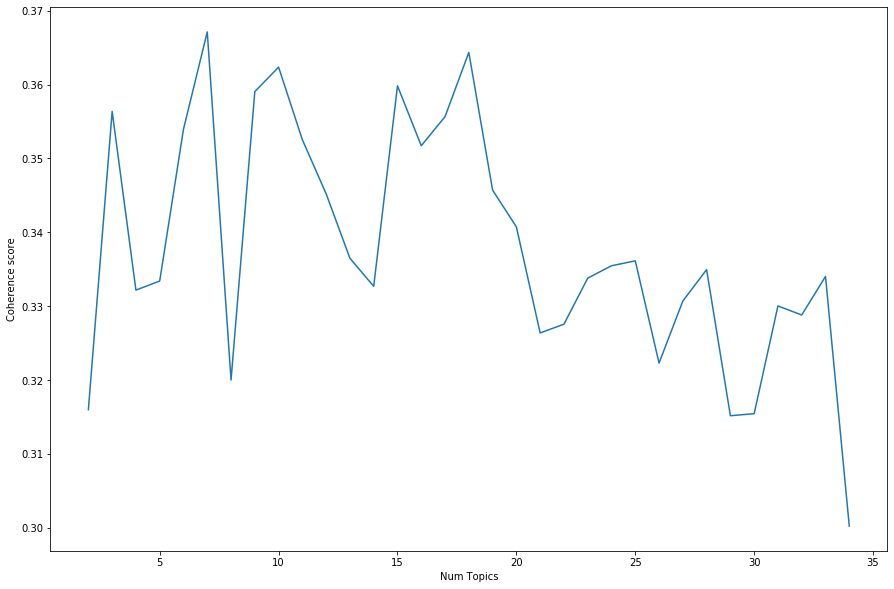

In [22]:
# Show graph
x = range(start, limit, step)
plt.figure(figsize=(15, 10))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
# plt.legend(("coherence_values"), loc='best')
plt.show()

In [23]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 6))

Num Topics = 2  has Coherence Value of 0.315971
Num Topics = 3  has Coherence Value of 0.356361
Num Topics = 4  has Coherence Value of 0.332166
Num Topics = 5  has Coherence Value of 0.333395
Num Topics = 6  has Coherence Value of 0.353949
Num Topics = 7  has Coherence Value of 0.367121
Num Topics = 8  has Coherence Value of 0.319991
Num Topics = 9  has Coherence Value of 0.35904
Num Topics = 10  has Coherence Value of 0.362353
Num Topics = 11  has Coherence Value of 0.352519
Num Topics = 12  has Coherence Value of 0.345202
Num Topics = 13  has Coherence Value of 0.336475
Num Topics = 14  has Coherence Value of 0.332677
Num Topics = 15  has Coherence Value of 0.359819
Num Topics = 16  has Coherence Value of 0.351712
Num Topics = 17  has Coherence Value of 0.355649
Num Topics = 18  has Coherence Value of 0.364344
Num Topics = 19  has Coherence Value of 0.345697
Num Topics = 20  has Coherence Value of 0.340726
Num Topics = 21  has Coherence Value of 0.326368
Num Topics = 22  has Coherenc

In [24]:
# Select the model and print the topics
index, value = max(enumerate(coherence_values), key=operator.itemgetter(1))
# index = 9
optimal_model = model_list[index]
model_topics = optimal_model.show_topics(num_topics=1000, formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.025*"man" + 0.018*"answer" + 0.017*"dorian" + 0.016*"cry" + 0.015*"time" '
  '+ 0.014*"hand" + 0.012*"back" + 0.010*"make" + 0.009*"long" + '
  '0.009*"light"'),
 (1,
  '0.019*"man" + 0.018*"room" + 0.015*"round" + 0.015*"life" + 0.013*"thing" + '
  '0.013*"back" + 0.012*"leave" + 0.012*"house" + 0.011*"sin" + 0.011*"door"'),
 (2,
  '0.032*"life" + 0.027*"make" + 0.025*"art" + 0.024*"thing" + 0.022*"find" + '
  '0.020*"man" + 0.015*"young" + 0.013*"beautiful" + 0.013*"charm" + '
  '0.011*"artist"'),
 (3,
  '0.044*"harry" + 0.035*"lord_henry" + 0.027*"good" + 0.022*"woman" + '
  '0.021*"people" + 0.021*"dorian" + 0.014*"dear" + 0.014*"-PRON-" + '
  '0.011*"laugh" + 0.011*"duchess"'),
 (4,
  '0.046*"dorian" + 0.022*"gray" + 0.021*"basil" + 0.020*"thing" + '
  '0.016*"face" + 0.015*"lord_henry" + 0.014*"feel" + 0.013*"picture" + '
  '0.012*"soul" + 0.012*"day"'),
 (5,
  '0.017*"gold" + 0.013*"world" + 0.012*"passion" + 0.011*"strange" + '
  '0.010*"white" + 0.009*"great" + 0.009

In [25]:
optimal_model.show_topic(0,10)

[('man', 0.02546816479400749),
 ('answer', 0.017977528089887642),
 ('dorian', 0.017228464419475654),
 ('cry', 0.01647940074906367),
 ('time', 0.0149812734082397),
 ('hand', 0.013982521847690388),
 ('back', 0.011735330836454432),
 ('make', 0.009987515605493134),
 ('long', 0.009488139825218476),
 ('light', 0.009238451935081148)]

In [26]:
for topic in sorted(optimal_model.show_topics(num_topics=1000, num_words=10, formatted=False), key=lambda x: x[0]):
    print('Topic {}: {}'.format(topic[0], [item[0] for item in topic[1]]))

Topic 0: ['man', 'answer', 'dorian', 'cry', 'time', 'hand', 'back', 'make', 'long', 'light']
Topic 1: ['man', 'room', 'round', 'life', 'thing', 'back', 'leave', 'house', 'sin', 'door']
Topic 2: ['life', 'make', 'art', 'thing', 'find', 'man', 'young', 'beautiful', 'charm', 'artist']
Topic 3: ['harry', 'lord_henry', 'good', 'woman', 'people', 'dorian', 'dear', '-PRON-', 'laugh', 'duchess']
Topic 4: ['dorian', 'gray', 'basil', 'thing', 'face', 'lord_henry', 'feel', 'picture', 'soul', 'day']
Topic 5: ['gold', 'world', 'passion', 'strange', 'white', 'great', 'silver', 'work', 'body', 'grow']
Topic 6: ['love', 'make', 'life', 'play', 'night', 'girl', 'feel', 'mother', 'sibyl', 'secret']


In [27]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.6689,"life, make, art, thing, find, man, young, beau...",The artist is the creator of beautiful things....
1,1,4.0,0.3631,"dorian, gray, basil, thing, face, lord_henry, ...",The studio was filled with the rich odour of r...
2,2,4.0,0.4510,"dorian, gray, basil, thing, face, lord_henry, ...",As they entered they saw Dorian Gray. He was ...
3,3,3.0,0.4756,"harry, lord_henry, good, woman, people, dorian...",At half-past twelve next day Lord Henry Wotton...
4,4,6.0,0.2764,"love, make, life, play, night, girl, feel, mot...","One afternoon, a month later, Dorian Gray was ..."
5,5,6.0,0.4676,"love, make, life, play, night, girl, feel, mot...","""Mother, Mother, I am so happy!"" whispered the..."
6,6,2.0,0.2997,"life, make, art, thing, find, man, young, beau...","""I suppose you have heard the news, Basil?"" sa..."
7,7,6.0,0.2892,"love, make, life, play, night, girl, feel, mot...","For some reason or other, the house was crowde..."
8,8,4.0,0.2794,"dorian, gray, basil, thing, face, lord_henry, ...",It was long past noon when he awoke. His vale...
9,9,4.0,0.4601,"dorian, gray, basil, thing, face, lord_henry, ...","As he was sitting at breakfast next morning, B..."


In [28]:
[text.split() for text in df_dominant_topic['Keywords'].tolist()]

[['life,',
  'make,',
  'art,',
  'thing,',
  'find,',
  'man,',
  'young,',
  'beautiful,',
  'charm,',
  'artist'],
 ['dorian,',
  'gray,',
  'basil,',
  'thing,',
  'face,',
  'lord_henry,',
  'feel,',
  'picture,',
  'soul,',
  'day'],
 ['dorian,',
  'gray,',
  'basil,',
  'thing,',
  'face,',
  'lord_henry,',
  'feel,',
  'picture,',
  'soul,',
  'day'],
 ['harry,',
  'lord_henry,',
  'good,',
  'woman,',
  'people,',
  'dorian,',
  'dear,',
  '-PRON-,',
  'laugh,',
  'duchess'],
 ['love,',
  'make,',
  'life,',
  'play,',
  'night,',
  'girl,',
  'feel,',
  'mother,',
  'sibyl,',
  'secret'],
 ['love,',
  'make,',
  'life,',
  'play,',
  'night,',
  'girl,',
  'feel,',
  'mother,',
  'sibyl,',
  'secret'],
 ['life,',
  'make,',
  'art,',
  'thing,',
  'find,',
  'man,',
  'young,',
  'beautiful,',
  'charm,',
  'artist'],
 ['love,',
  'make,',
  'life,',
  'play,',
  'night,',
  'girl,',
  'feel,',
  'mother,',
  'sibyl,',
  'secret'],
 ['dorian,',
  'gray,',
  'basil,',
  'thing

In [29]:
for idx, row in df_dominant_topic.iterrows():
    print('{}. Dominant keywords: {}'.format(row['Document_No'], row['Keywords'].split(', ')[:5]))

0. Dominant keywords: ['life', 'make', 'art', 'thing', 'find']
1. Dominant keywords: ['dorian', 'gray', 'basil', 'thing', 'face']
2. Dominant keywords: ['dorian', 'gray', 'basil', 'thing', 'face']
3. Dominant keywords: ['harry', 'lord_henry', 'good', 'woman', 'people']
4. Dominant keywords: ['love', 'make', 'life', 'play', 'night']
5. Dominant keywords: ['love', 'make', 'life', 'play', 'night']
6. Dominant keywords: ['life', 'make', 'art', 'thing', 'find']
7. Dominant keywords: ['love', 'make', 'life', 'play', 'night']
8. Dominant keywords: ['dorian', 'gray', 'basil', 'thing', 'face']
9. Dominant keywords: ['dorian', 'gray', 'basil', 'thing', 'face']
10. Dominant keywords: ['man', 'room', 'round', 'life', 'thing']
11. Dominant keywords: ['gold', 'world', 'passion', 'strange', 'white']
12. Dominant keywords: ['man', 'answer', 'dorian', 'cry', 'time']
13. Dominant keywords: ['man', 'room', 'round', 'life', 'thing']
14. Dominant keywords: ['man', 'room', 'round', 'life', 'thing']
15. Domi

In [30]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.4990,"man, answer, dorian, cry, time, hand, back, ma...","A cold rain began to fall, and the blurred str..."
1,1.0,0.4634,"man, room, round, life, thing, back, leave, ho...",At nine o'clock the next morning his servant c...
2,2.0,0.6689,"life, make, art, thing, find, man, young, beau...",The artist is the creator of beautiful things....
3,3.0,0.4756,"harry, lord_henry, good, woman, people, dorian...",At half-past twelve next day Lord Henry Wotton...
4,4.0,0.4601,"dorian, gray, basil, thing, face, lord_henry, ...","As he was sitting at breakfast next morning, B..."
5,5.0,0.4504,"gold, world, passion, strange, white, great, s...","For years, Dorian Gray could not free himself ..."
6,6.0,0.4676,"love, make, life, play, night, girl, feel, mot...","""Mother, Mother, I am so happy!"" whispered the..."


In [31]:
for idx, row in sent_topics_sorteddf_mallet.iterrows():
    print('Topic number {}'.format(int(row['Topic_Num'])))
    print('Keywords: {}'.format(row['Keywords']))
    print()
    print(row['Text'])
    print()

Topic number 0
Keywords: man, answer, dorian, cry, time, hand, back, make, long, light

A cold rain began to fall, and the blurred street-lamps looked ghastly in the dripping mist.  The public-houses were just closing, and dim men and women were clustering in broken groups round their doors.  From some of the bars came the sound of horrible laughter.  In others, drunkards brawled and screamed.  Lying back in the hansom, with his hat pulled over his forehead, Dorian Gray watched with listless eyes the sordid shame of the great city, and now and then he repeated to himself the words that Lord Henry had said to him on the first day they had met, "To cure the soul by means of the senses, and the senses by means of the soul."  Yes, that was the secret.  He had often tried it, and would try it again now.  There were opium dens where one could buy oblivion, dens of horror where the memory of old sins could be destroyed by the madness of sins that were new.  The moon hung low in the sky like a

In [32]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = sent_topics_sorteddf_mallet[['Topic_Num', 'Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Percent_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Percent_Documents
0,0.0,"man, answer, dorian, cry, time, hand, back, ma...",3,0.1429
1,1.0,"man, room, round, life, thing, back, leave, ho...",4,0.1905
2,2.0,"life, make, art, thing, find, man, young, beau...",2,0.0952
3,3.0,"harry, lord_henry, good, woman, people, dorian...",3,0.1429
4,4.0,"dorian, gray, basil, thing, face, lord_henry, ...",5,0.2381
5,5.0,"gold, world, passion, strange, white, great, s...",1,0.0476
6,6.0,"love, make, life, play, night, girl, feel, mot...",3,0.1429


In [33]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    pd.set_option('display.max_colwidth', -1)
    display(df_dominant_topics)

,Dominant_Topic,Topic_Keywords,Num_Documents,Percent_Documents
0,0.0,"man, answer, dorian, cry, time, hand, back, make, long, light",3,0.1429
1,1.0,"man, room, round, life, thing, back, leave, house, sin, door",4,0.1905
2,2.0,"life, make, art, thing, find, man, young, beautiful, charm, artist",2,0.0952
3,3.0,"harry, lord_henry, good, woman, people, dorian, dear, -PRON-, laugh, duchess",3,0.1429
4,4.0,"dorian, gray, basil, thing, face, lord_henry, feel, picture, soul, day",5,0.2381
5,5.0,"gold, world, passion, strange, white, great, silver, work, body, grow",1,0.0476
6,6.0,"love, make, life, play, night, girl, feel, mother, sibyl, secret",3,0.1429


In [34]:
df_dominant_topics.to_csv('df_dominant_topics.csv', index=False)

# LDA using individual sentences as documents

In [35]:
from nltk import tokenize

In [36]:
# Convert to list
data = []
for book in bookDict:
    for chapter in bookDict[book]:
        data.extend(tokenize.sent_tokenize(bookDict[book][chapter]))

In [37]:
# Tokenize into words
print('Tokenizing')
data_words = list(sent_to_words(data))

# Build the bigram and trigram models
print('Creating bigrams and trigrams')
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
print('Building bigram and trigram models')
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# Remove Stop Words
print('Removing stopwords')
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
print('Forming bigrams')
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
print('Lemmatizing')
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# Create Dictionary
print('Creating dictionary')
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
print('Creating corpus')
texts = data_lemmatized

# Term Document Frequency
print('Creating term frequency list')
corpus = [id2word.doc2bow(text) for text in texts]

Tokenizing
Creating bigrams and trigrams
Building bigram and trigram models
Removing stopwords
Forming bigrams
Lemmatizing
Creating dictionary
Creating corpus
Creating term frequency list


In [38]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

/Users/william/Fullstack/TrypNoteTextEngine/venv/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [39]:
# Can take a long time to run.
limit=35; start=2; step=1;
model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=data_lemmatized,
                                                        start=start,
                                                        limit=limit,
                                                        step=step)

Calculating 2-topic model
Calculating 3-topic model
Calculating 4-topic model
Calculating 5-topic model
Calculating 6-topic model
Calculating 7-topic model
Calculating 8-topic model
Calculating 9-topic model
Calculating 10-topic model
Calculating 11-topic model
Calculating 12-topic model
Calculating 13-topic model
Calculating 14-topic model
Calculating 15-topic model
Calculating 16-topic model
Calculating 17-topic model
Calculating 18-topic model
Calculating 19-topic model
Calculating 20-topic model
Calculating 21-topic model
Calculating 22-topic model
Calculating 23-topic model
Calculating 24-topic model
Calculating 25-topic model
Calculating 26-topic model
Calculating 27-topic model
Calculating 28-topic model
Calculating 29-topic model
Calculating 30-topic model
Calculating 31-topic model
Calculating 32-topic model
Calculating 33-topic model
Calculating 34-topic model


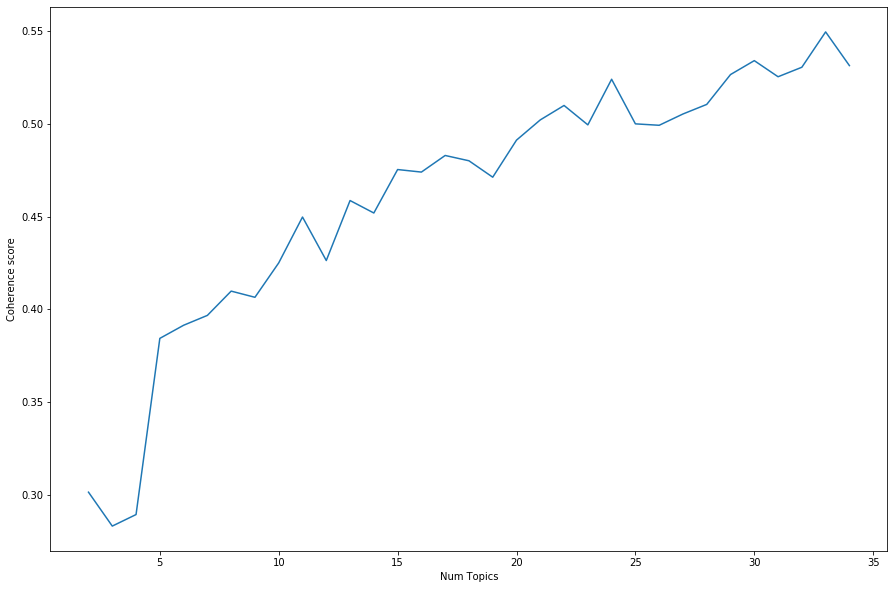

In [40]:
# Show graph
x = range(start, limit, step)
plt.figure(figsize=(15, 10))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
# plt.legend(("coherence_values"), loc='best')
plt.show()

In [41]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 6))

Num Topics = 2  has Coherence Value of 0.301563
Num Topics = 3  has Coherence Value of 0.283289
Num Topics = 4  has Coherence Value of 0.289508
Num Topics = 5  has Coherence Value of 0.384432
Num Topics = 6  has Coherence Value of 0.391501
Num Topics = 7  has Coherence Value of 0.396822
Num Topics = 8  has Coherence Value of 0.4099
Num Topics = 9  has Coherence Value of 0.406572
Num Topics = 10  has Coherence Value of 0.425106
Num Topics = 11  has Coherence Value of 0.449824
Num Topics = 12  has Coherence Value of 0.426382
Num Topics = 13  has Coherence Value of 0.458705
Num Topics = 14  has Coherence Value of 0.45199
Num Topics = 15  has Coherence Value of 0.475408
Num Topics = 16  has Coherence Value of 0.474039
Num Topics = 17  has Coherence Value of 0.482987
Num Topics = 18  has Coherence Value of 0.480131
Num Topics = 19  has Coherence Value of 0.471283
Num Topics = 20  has Coherence Value of 0.491257
Num Topics = 21  has Coherence Value of 0.50216
Num Topics = 22  has Coherence V

In [42]:
# Select the model and print the topics
index, value = max(enumerate(coherence_values), key=operator.itemgetter(1))
index = 17
optimal_model = model_list[index]
model_topics = optimal_model.show_topics(num_topics=1000, formatted=False)

In [43]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# Compute Perplexity
print ('Perplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print ('Coherence Score: ', coherence_lda)

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis)

Perplexity:  -8.523250962995556
Coherence Score:  0.44902822268711307


/Users/william/Fullstack/TrypNoteTextEngine/venv/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [44]:
for topic in sorted(optimal_model.show_topics(num_topics=1000, num_words=10, formatted=False), key=lambda x: x[0]):
    print('Topic {}: {}'.format(topic[0], [item[0] for item in topic[1]]))

Topic 0: ['good', 'smile', 'meet', 'mother', 'remember', 'artist', 'true', 'reason', 'suppose', 'campbell']
Topic 1: ['lord_henry', 'back', 'table', 'book', 'write', 'lie', 'send', 'street', 'month', 'evening']
Topic 2: ['time', 'long', 'put', 'word', 'give', 'bear', 'ah', 'wait', 'sibyl', 'stop']
Topic 3: ['feel', 'world', 'passion', 'afraid', 'secret', 'pleasure', 'curious', 'hideous', 'nature', 'influence']
Topic 4: ['life', 'love', 'live', 'great', 'understand', 'late', 'happy', 'sort', 'lead', 'lord_henry']
Topic 5: ['dorian', 'gray', 'mr', 'dear', 'grow', 'good_bye', 'glad', 'miss', 'turn', 'breath']
Topic 6: ['art', 'wonderful', 'thing', 'painter', 'real', 'simply', 'leave', 'show', 'give', 'kind']
Topic 7: ['face', 'day', 'moment', 'place', 'picture', 'portrait', 'change', 'music', 'fall', 'morning']
Topic 8: ['white', 'leave', 'paint', 'beautiful', 'red', 'boy', 'die', 'death', 'flower', 'read']
Topic 9: ['make', 'lad', 'strange', 'beauty', 'terrible', 'youth', 'mad', 'age', '

In [45]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

/Users/william/Fullstack/TrypNoteTextEngine/venv/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [46]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = sent_topics_sorteddf_mallet[['Topic_Num', 'Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Percent_Documents']

# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

In [47]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    pd.set_option('display.max_colwidth', -1)
    display(df_dominant_topics)

,Dominant_Topic,Topic_Keywords,Num_Documents,Percent_Documents
0.0,0.0,"man, answer, dorian, cry, time, hand, back, make, long, light",897,0.1378
1.0,1.0,"man, room, round, life, thing, back, leave, house, sin, door",293,0.0450
2.0,2.0,"life, make, art, thing, find, man, young, beautiful, charm, artist",397,0.0610
3.0,3.0,"harry, lord_henry, good, woman, people, dorian, dear, -PRON-, laugh, duchess",368,0.0565
4.0,4.0,"dorian, gray, basil, thing, face, lord_henry, feel, picture, soul, day",397,0.0610
5.0,5.0,"gold, world, passion, strange, white, great, silver, work, body, grow",435,0.0668
6.0,6.0,"love, make, life, play, night, girl, feel, mother, sibyl, secret",286,0.0439
7.0,NaN,NaN,287,0.0441
8.0,NaN,NaN,270,0.0415
9.0,NaN,NaN,323,0.0496
